

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

In [ ]:

# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

Found existing installation: Pillow 5.3.0
Uninstalling Pillow-5.3.0:
  Successfully uninstalled Pillow-5.3.0
  Using cached Pillow-5.3.0-cp37-cp37m-manylinux1_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


5.3.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!ls /content/gdrive/ # выясняем, как называется наш корневой каталог
!ls -l /content/gdrive/MyDrive/journey-springfield.zip # загруженный архив виден
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip # Распаковываем архив
!ls -1
!ls train
!ls testset

MyDrive
-rw------- 1 root root 546224286 Nov 30 16:26 /content/gdrive/MyDrive/journey-springfield.zip
replace characters_illustration.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: characters_illustration.png
gdrive
sample_data
sample_submission.csv
testset
train
simpsons_dataset
testset


In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Thu Dec  2 14:57:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    25W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from torch.optim import lr_scheduler
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [ ]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """

    """
    При инициализации запоминает файлы и режим обученя
    Если не тестовый режим то преобразовывает строковые классы в id
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    """
    Извлекает по индесу фото
    - делает rescale -> 224 x 224
    - нормализация изображение на основе ImageNet
    Если в тестовом режме -> возвращает только фото X
    Иначе возвращает фото X  и label id Y
    """
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            # передаем среднее и стандартное отклонение
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
    #ресайз изображение -> 224 x 224                                                                            
    def _prepare_sample(self,      image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
"""
Показывает картинку по тензору
- Приводит пиксели из нормального распределения к 0-255
- Потом приводит к равномерному распределению 0-1
- Показывает подпись если ее передали
"""
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg'))) # извлекаем данный для трейна и валидации
test_files = sorted(list(TEST_DIR.rglob('*.jpg'))) # извлекаем данный для теста


In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files] # извлекаем лейблы для трейна и валидации
train_files, val_files, train_labels, val_labels = train_test_split(train_val_files, train_val_labels, test_size=0.25, # 25% трейна - валидация
                                          stratify=train_val_labels)

In [ ]:
print(f'Всего файлов для трейна и валидации: {len(train_val_files)}')
print(f'Файлов для трейна: {len(train_files)}')
print(f'Файлов для валидации: {len(val_files)}')
print(f'Файлов для теста: {len(test_files)}')

Всего файлов для трейна и валидации: 20933
Файлов для трейна: 15699
Файлов для валидации: 5234
Файлов для теста: 991


In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val') #датасет для валидации

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

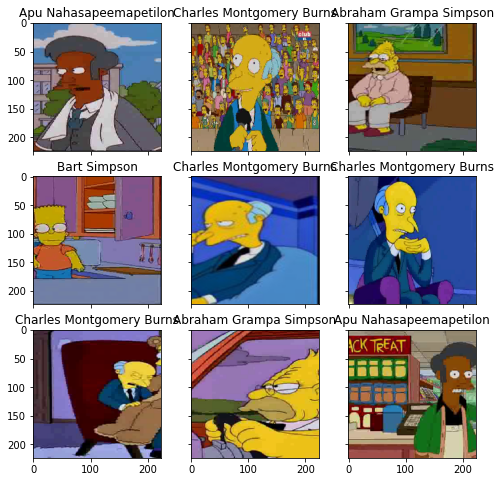

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE) # переводим X на гпу
        labels = labels.to(DEVICE) # и Y
        optimizer.zero_grad()

        outputs = model(inputs) #считаем выходы - логиты
        loss = criterion(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска
        preds = torch.argmax(outputs, 1) # id ответа - максимум среди логитов
        running_loss += loss.item() * inputs.size(0) #складываем лосс
        running_corrects += torch.sum(preds == labels.data) # складываем колво правильных
        processed_data += inputs.size(0) # сколько всего данных обработали
    
    #считаем средние по всей эпохи
    train_loss = running_loss / processed_data 
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval() # перевод модели в режим предсказания
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE) # переводим данные на гпу
        labels = labels.to(DEVICE)

        # считаем логиты, лосс, предсказания без вычисления градиентов
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    # возвращаем средние лосс и accuracy по всей валидационной выборке
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    # Обертываем данные в даталоадеры  и шафлим их
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters()) # задаем оптимайзер
        criterion = nn.CrossEntropyLoss() # функцию потерь

        for epoch in range(epochs): # проходимся по эпохам
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt) # смотрим лосс и точность на эпохе
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion) # смотрим лосс и точность на валидации
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, # выводим лог обучения
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE) # делаем предсказания на гпу
            model.eval() # переводим модель в режим предсказания
            outputs = model(inputs).cpu() # храним их на цпу
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy() # переводим логиты в вероятности
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels)) # общее кол-во классов лейблов
simple_cnn = SimpleCnn(n_classes).to(DEVICE) # переводим модель на гпу
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=64)

epoch:   0%|          | 0/4 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

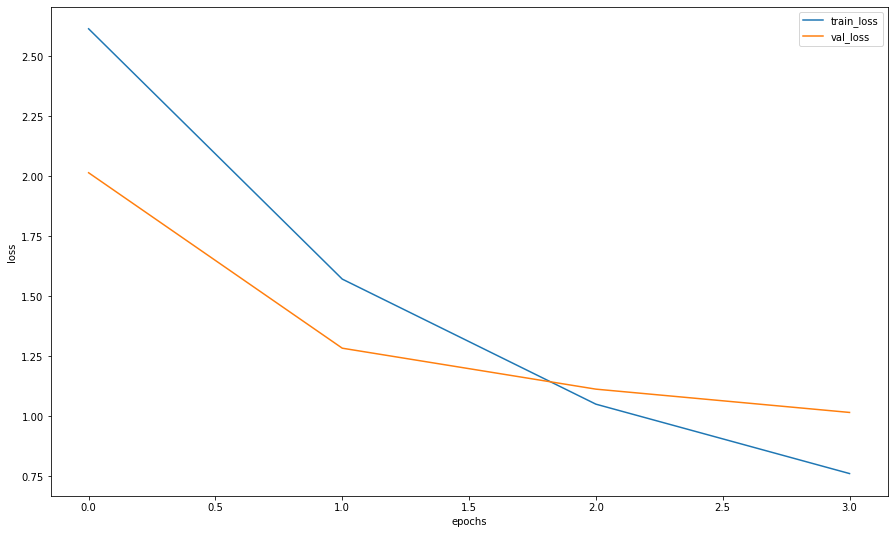

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000)) #семплируем индексы
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
print(preds_class)
print(y_pred)
print(actual_labels)

['bart_simpson', 'lisa_simpson', 'bart_simpson', 'sideshow_bob', 'moe_szyslak', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'lisa_simpson', 'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon', 'abraham_grampa_simpson', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'charles_montgomery_burns', 'lisa_simpson', 'principal_skinner']
[ 4 20  4 37 27  0  0  4 20  2  2  2  0  6  2  6  0  6 20 32]
[4, 4, 4, 2, 4, 4, 0, 4, 6, 2, 2, 2, 0, 6, 2, 6, 6, 6, 4, 0]


In [ ]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.6

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

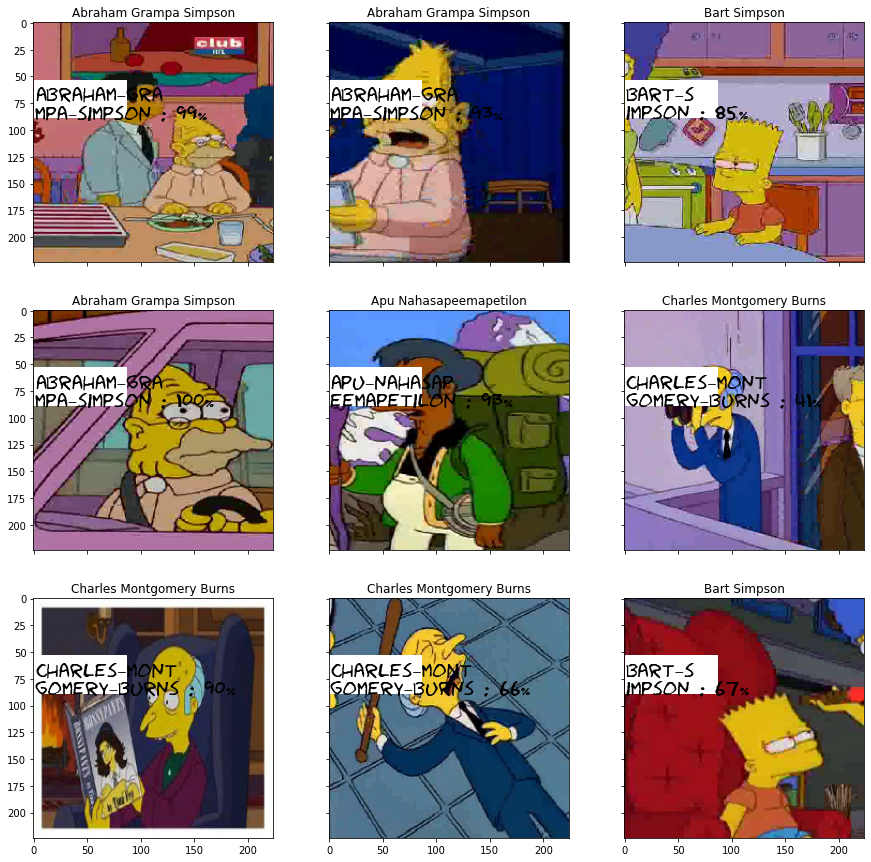

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(15, 15), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=20, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) # обратный автоэнкодинг
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 
! mkdir answers

answers			     gdrive		sample_data	       testset
characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
mkdir: cannot create directory ‘answers’: File exists


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('answers/simple_cnn_baseline2.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


# ***МОЙ DEEP LEARNING***

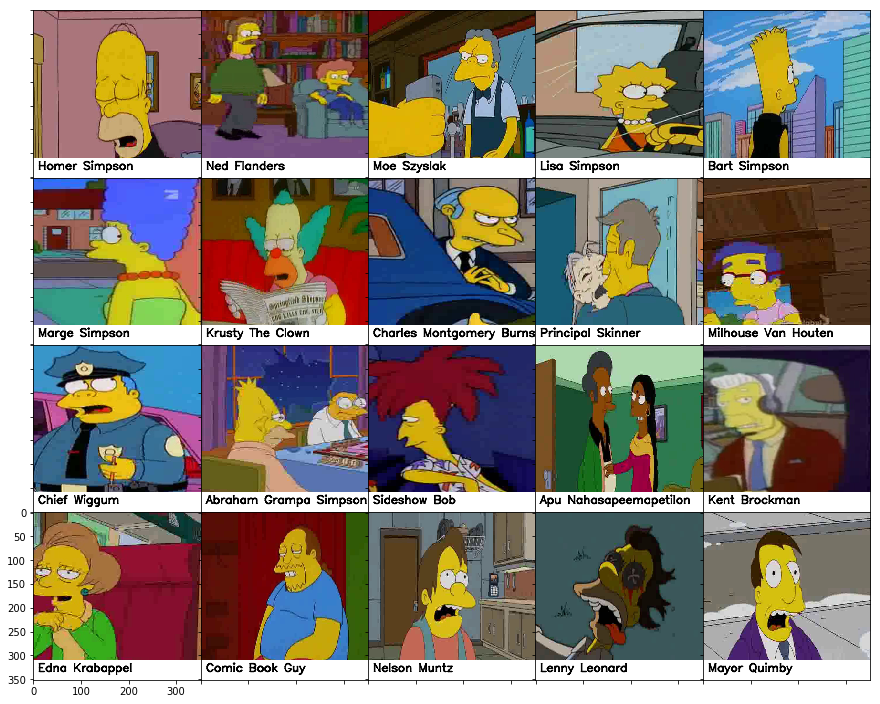

In [ ]:
from IPython.display import Image
Image(filename='/content/characters_illustration.png') 

In [ ]:
from collections import Counter
counter = Counter(train_val_labels)
print(counter)
print(counter.keys())

Counter({'homer_simpson': 2246, 'ned_flanders': 1454, 'moe_szyslak': 1452, 'lisa_simpson': 1354, 'bart_simpson': 1342, 'marge_simpson': 1291, 'krusty_the_clown': 1206, 'principal_skinner': 1194, 'charles_montgomery_burns': 1193, 'milhouse_van_houten': 1079, 'chief_wiggum': 986, 'abraham_grampa_simpson': 913, 'sideshow_bob': 877, 'apu_nahasapeemapetilon': 623, 'kent_brockman': 498, 'comic_book_guy': 469, 'edna_krabappel': 457, 'nelson_muntz': 358, 'lenny_leonard': 310, 'mayor_quimby': 246, 'waylon_smithers': 181, 'maggie_simpson': 128, 'groundskeeper_willie': 121, 'barney_gumble': 106, 'selma_bouvier': 103, 'carl_carlson': 98, 'ralph_wiggum': 89, 'patty_bouvier': 72, 'martin_prince': 71, 'professor_john_frink': 65, 'snake_jailbird': 55, 'cletus_spuckler': 47, 'rainier_wolfcastle': 45, 'agnes_skinner': 42, 'sideshow_mel': 40, 'otto_mann': 32, 'fat_tony': 27, 'gil': 27, 'miss_hoover': 17, 'disco_stu': 8, 'troy_mcclure': 8, 'lionel_hutz': 3})
dict_keys(['abraham_grampa_simpson', 'agnes_ski

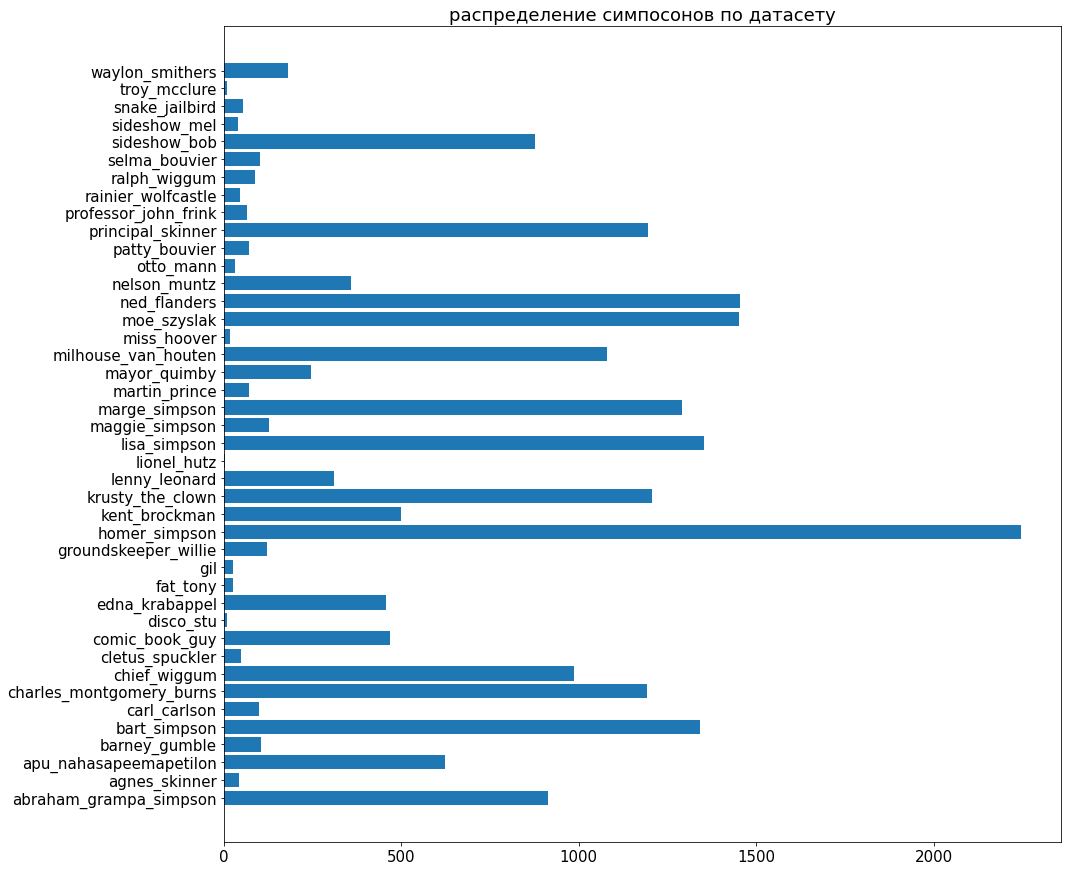

In [ ]:
plt.figure(figsize=(15, 15))
plt.rc('font', size=15) 
plt.barh(list(counter.keys()), counter.values())
plt.title('распределение симпосонов по датасету')
plt.rc('font', size=10) 

In [ ]:
num_to_show = 9
popular_t = counter.most_common(num_to_show)
rare_t = counter.most_common()[::-1][:num_to_show]
popular = list(list(zip(*popular_t))[0])
nums_popular = list(list(zip(*popular_t))[1])
rare = list(list(zip(*rare_t))[0])
nums_rare = list(list(zip(*rare_t))[1])
print(nums_popular)

[2246, 1454, 1452, 1354, 1342, 1291, 1206, 1194, 1193]


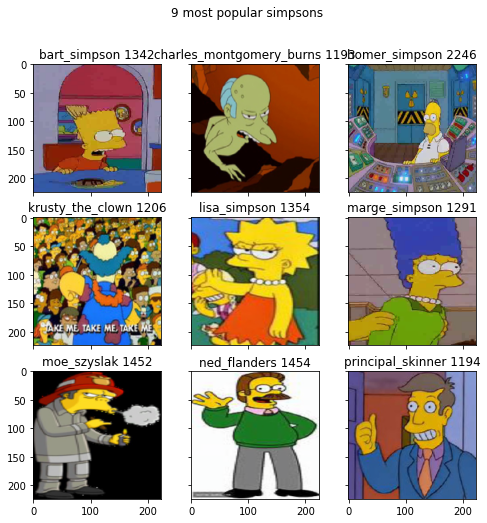

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
plt.suptitle("9 most popular simpsons")
for fig_x in ax.flatten():
    for elem in val_dataset:
        pict, label = elem
        label = label_encoder.inverse_transform([label])[0]
        if label in popular:
            index = popular.index(label)
            imshow(pict.cpu(), title=label+' '+str(nums_popular[index]), plt_ax=fig_x)
            del popular[index]
            del nums_popular[index]
            break

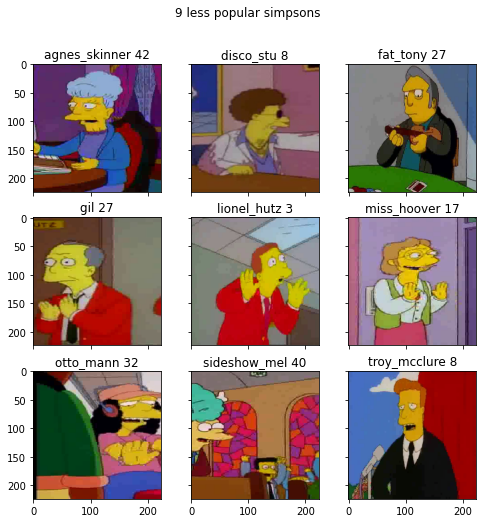

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
plt.suptitle("9 less popular simpsons")
for fig_x in ax.flatten():
    for elem in val_dataset:
        pict, label = elem
        label = label_encoder.inverse_transform([label])[0]
        if label in rare:
            index = rare.index(label)
            imshow(pict.cpu(), title=label+' '+str(nums_rare[index]), plt_ax=fig_x)
            del rare[index]
            del nums_rare[index]
            break

In [ ]:
class MySimpleCnn(nn.Module):
    '''
    BatchNorm2d for conv added
    3 layer classifier Dropout added
    '''
  
    def __init__(self, n_classes): #n_classes = 42 for simpsons
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.out = nn.Sequential(
            nn.Linear(96*5*5, 1024),
            nn.ReLU(),
            nn.Dropout(),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.3),

            nn.Linear(512, n_classes)
        )
        #self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
#lr_scheduler and checkpointing added
def my_train(train_files, val_files, model, epochs, batch_size):
    # Обертываем данные в даталоадеры  и шафлим их
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    best_acc = 0
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters()) # задаем оптимайзер
        criterion = nn.CrossEntropyLoss() # функцию потерь
        scheduler = lr_scheduler.StepLR(opt, step_size = 4, gamma = 0.1) #lr decay

        for epoch in range(epochs): # проходимся по эпохам
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt) # смотрим лосс и точность на эпохе
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion) # смотрим лосс и точность на валидации
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc > best_acc: #checkpointing
                best_acc = val_acc
                best_model_wts = model.state_dict()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, # выводим лог обучения
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    return best_model_wts, history

In [ ]:
simple_cnn = MySimpleCnn(42).to(DEVICE)

In [ ]:
wts, history = my_train(train_dataset, val_dataset, model=simple_cnn, epochs=9, batch_size=64)

epoch:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


loss 1.783237402454608


epoch:  11%|█         | 1/9 [02:59<23:55, 179.39s/it]


Epoch 001 train_loss: 1.7832     val_loss 1.3616 train_acc 0.5146 val_acc 0.6311
loss 1.2421247004832392


epoch:  22%|██▏       | 2/9 [05:55<20:42, 177.43s/it]


Epoch 002 train_loss: 1.2421     val_loss 1.0049 train_acc 0.6495 val_acc 0.7146
loss 0.9339377544087067


epoch:  33%|███▎      | 3/9 [08:52<17:43, 177.30s/it]


Epoch 003 train_loss: 0.9339     val_loss 0.8197 train_acc 0.7279 val_acc 0.7788
loss 0.6311051299886511


epoch:  44%|████▍     | 4/9 [11:50<14:47, 177.50s/it]


Epoch 004 train_loss: 0.6311     val_loss 0.6748 train_acc 0.8181 val_acc 0.8175
loss 0.5339822759976987


epoch:  56%|█████▌    | 5/9 [14:48<11:50, 177.62s/it]


Epoch 005 train_loss: 0.5340     val_loss 0.6537 train_acc 0.8420 val_acc 0.8259
loss 0.4877353334770103


epoch:  67%|██████▋   | 6/9 [17:43<08:50, 176.91s/it]


Epoch 006 train_loss: 0.4877     val_loss 0.6364 train_acc 0.8575 val_acc 0.8315
loss 0.4524295032764743


epoch:  78%|███████▊  | 7/9 [20:40<05:53, 176.92s/it]


Epoch 007 train_loss: 0.4524     val_loss 0.6162 train_acc 0.8646 val_acc 0.8380
loss 0.39995084275743126


epoch:  89%|████████▉ | 8/9 [23:34<02:56, 176.03s/it]


Epoch 008 train_loss: 0.4000     val_loss 0.6098 train_acc 0.8808 val_acc 0.8407
loss 0.40143333966697553


epoch: 100%|██████████| 9/9 [26:30<00:00, 176.77s/it]


Epoch 009 train_loss: 0.4014     val_loss 0.6083 train_acc 0.8784 val_acc 0.8429


In [ ]:
model = simple_cnn
model.load_state_dict(wts)

<All keys matched successfully>

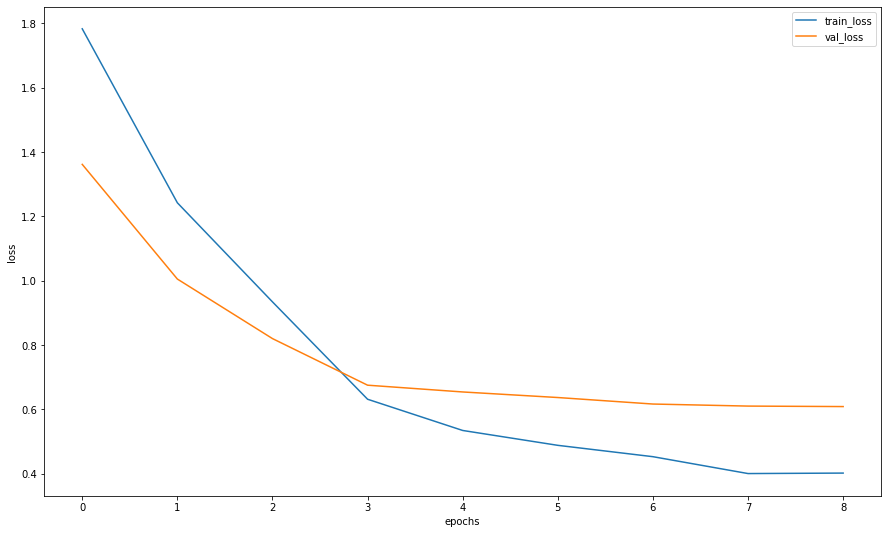

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE) # делаем предсказания на гпу
            model.eval() # переводим модель в режим предсказания
            outputs = model(inputs).cpu() # храним их на цпу
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy() # переводим логиты в вероятности
    return probs

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
def calc_f1(val_loader):
    model.eval()
    with torch.no_grad():
        logits = []
        ans = []
        for x, y in val_loader:
            x = x.to(DEVICE)
            out = model(x).cpu()
            logits.append(out)
            ans.append(y)
    preds = torch.argmax(torch.cat(logits), -1)
    return f1_score(torch.cat(ans), preds, average='micro')
print(calc_f1(val_loader))

0.8429499426824608


In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) # обратный автоэнкодинг
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
! mkdir test
my_submit.to_csv('test/Improved_baseline.csv', index=False)